Adapted from Mathilde Koch, INRAe, Faulon's group

The aim of this notebook is to generate results presented in Figure 1e of the paper.

# Python libraries imports

In [4]:
import numpy as np

import matplotlib.pyplot as plt

import sklearn
from sklearn import linear_model
from sklearn import decomposition
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score

import time
import datetime
import random
import csv
import os
import copy
from collections import Mapping, namedtuple, defaultdict, Sequence

# This is data that has already been generated due to DoE methodology
import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

In [5]:
folder_for_data = "data/no_controls"

# Importing data from the study

In [6]:
plate_1 = "{}/plate_AL_1_raw_yield_and_std.csv".format(folder_for_data)
plate_1_array = np.genfromtxt(plate_1, delimiter=',', skip_header = 1, dtype = "float")

plate_2 = "{}/plate_AL_2_raw_yield_and_std.csv".format(folder_for_data)
plate_2_array = np.genfromtxt(plate_2, delimiter=',', skip_header = 1, dtype = "float")

plate_3 = "{}/plate_AL_3_raw_yield_and_std.csv".format(folder_for_data)
plate_3_array = np.genfromtxt(plate_3, delimiter=',', skip_header = 1, dtype = "float")

plate_4 = "{}/plate_AL_4_raw_yield_and_std.csv".format(folder_for_data)
plate_4_array = np.genfromtxt(plate_4, delimiter=',', skip_header = 1, dtype = "float")

plate_5 = "{}/plate_AL_5_raw_yield_and_std.csv".format(folder_for_data)
plate_5_array = np.genfromtxt(plate_5, delimiter=',', skip_header = 1, dtype = "float")

plate_6 = "{}/plate_AL_6_raw_yield_and_std.csv".format(folder_for_data)
plate_6_array = np.genfromtxt(plate_6, delimiter=',', skip_header = 1, dtype = "float")

plate_7 = "{}/plate_AL_7_raw_yield_and_std.csv".format(folder_for_data)
plate_7_array = np.genfromtxt(plate_7, delimiter=',', skip_header = 1, dtype = "float")

plate_8 = "{}/plate_AL_8_raw_yield_and_std.csv".format(folder_for_data)
plate_8_array = np.genfromtxt(plate_8, delimiter=',', skip_header = 1, dtype = "float")

plate_9 = "{}/plate_AL_9_raw_yield_and_std.csv".format(folder_for_data)
plate_9_array = np.genfromtxt(plate_9, delimiter=',', skip_header = 1, dtype = "float")

plate_10 = "{}/plate_AL_10_raw_yield_and_std.csv".format(folder_for_data)
plate_10_array = np.genfromtxt(plate_10, delimiter=',', skip_header = 1, dtype = "float")

# Choosing plates to test

This study was performed using a random seed, so the methodology presented below holds but exact values used for the next iteration should not be expected. Exemple on filling of data is presented below.

In [7]:
def data_from_iteration(iteration_number = 1):
    
    """
    Obtain data from the desired number of iterations, and not the whole data.
    """
    
    full_plates_list = [plate_1_array, plate_2_array, plate_3_array, plate_4_array, plate_5_array,
                        plate_6_array, plate_7_array, plate_8_array, plate_9_array, plate_10_array]
    selected_plates = full_plates_list[0:iteration_number]
    current_data = np.concatenate(selected_plates, axis = 0)
    return(current_data)

In [8]:
data = data_from_iteration(3)

In [9]:
print(data.shape)

(303, 13)


# Defining tested concentrations and volumes

In [10]:
# Maximum concentrations for each component

extract_max = 30
mg_gluta_max = 4
K_gluta_max = 80
aa_max = 1.5
peg_max = 2
hepes_max = 50
trna_max = 0.2
coa_max = 0.26
nad_max = 0.33
camp_max = 0.75
folinic_acid_max = 0.068
spemidine_max = 1
pga_max = 30
nucleo_mix_max = 1.5
DNA_max = 50

promoter_max = 10
RBS_max = 10

In [11]:
# Concentration data: tested concentrations for each reagent

mg_gluta_conc = [0.1, 0.3, 0.5, 1]
K_gluta_conc = [0.1, 0.3, 0.5, 1]
aa_conc = [0.1, 0.3, 0.5, 1]
trna_conc = [0.1, 0.3, 0.5, 1]
coa_conc = [0.1, 0.3, 0.5, 1]
nad_conc = [0.1, 0.3, 0.5, 1]
camp_conc = [0.1, 0.3, 0.5, 1]
folinic_acid_conc = [0.1, 0.3, 0.5, 1]
spermidine_conc = [0.1, 0.3, 0.5, 1]
pga_conc = [0.1, 0.3, 0.5, 1]
nucleo_conc = [0.1, 0.3, 0.5, 1]

# Reshaping data for following tests

In [12]:
initial_max = []  # This stores maximum values for normalisation later on.
X_data, y_data, y_std_data = data[:, 0:11], data[:, 11], data[:, 12]

for i in range(X_data.shape[1]):
    initial_max.append(copy.deepcopy(max(X_data[:,i])))
    X_data[:,i] = X_data[:,i]/max(X_data[:,i])

print(initial_max)
# my_current_data = np.concatenate((plate_1a_array, plate_1b_array), axis = 0)

[0.33, 0.068, 0.26, 1.5, 1.0, 30.0, 1.5, 0.2, 4.0, 0.75, 80.0]


In [13]:
# Maximum yield attained at those iterations
best_of = np.amax(y_data)
print(best_of)

1.5358


# Defining essential functions

In [14]:
def present_in_array_index(new_sample, array, size = 11):
    
    """
    Verify if a sample is present in an array.
    """
    
    present = False
    new_sample = np.reshape(np.array(new_sample), (1,size))
    for i in range(array.shape[0]):
        if np.array_equiv(array[i,:],new_sample):
            present = True
            break
    return(present, i)

In [15]:
def select_current_best_model(X, y, models_number = 10, 
                              verbose = False, 
                             MLP = True,
                             visu = False,
                             model_name = "test"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

    trained_model_list = []
    
    # Training all models
    
    for i in range(models_number):
        X_train, y_train = X, y
        
        if MLP:
            
            other_MLP = MLPRegressor(hidden_layer_sizes  = (10, 100, 100, 20), solver = "adam", max_iter = 20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            other_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(other_MLP)

            big_MLP = MLPRegressor(hidden_layer_sizes  = (100,100, 20),solver = "adam", max_iter = 20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            big_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(big_MLP)

            medium_MLP = MLPRegressor(hidden_layer_sizes  = (40, 10), solver = "adam", max_iter = 20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            medium_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(medium_MLP)
  
            small_MLP = MLPRegressor(hidden_layer_sizes  = (10), solver = "adam", max_iter = 20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            small_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(small_MLP)
        
    # Evaluating all models
    
    all_scores = []
    
    for i in range(len(trained_model_list)):
        selected_mdoel = trained_model_list[i]
        y_pred = selected_mdoel.predict(X)
        score = sklearn.metrics.r2_score(y, y_pred)
        all_scores.append(score)

    try:
        best_index = all_scores.index(max(all_scores))
        best_score = all_scores[best_index]
    except ValueError:
        best_index = 0
    if verbose:
        print(all_scores)
        print("Best index is {}".format(best_index))
        print("Best score is {}".format(best_score))
    best_model = trained_model_list[best_index]
    if visu:        
        model = best_model
        y_pred = model.predict(X)
        score = sklearn.metrics.r2_score(y, y_pred)
        fig, ax = plt.subplots()
        ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_title("Model prediction for model {}: {}".format(model_name, score))
        ax.set_ylabel('Predicted')
        plt.show()
    return(best_model, best_score)

# Ensemble model training

This part of the code trains the model on all available data, to generate an ensemble of models used for later predictions. Parameters used for the study were:
- n = 25 models for ensemble size
- models_number = 10 for repeating training

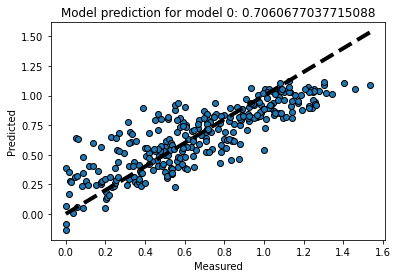

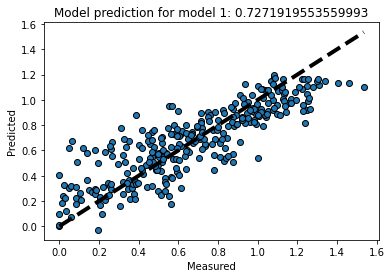

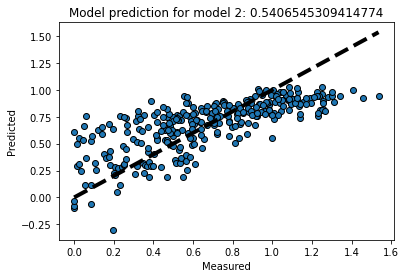

In [16]:
training_mlp_start_time = time.time()
ensemble_MLP = []
n = 3
# n = 25

for i in range(n):
    current_best, best_score = select_current_best_model(X_data, y_data, 
                                             models_number = 3, verbose = False,
                                             MLP = True,
                                             visu = True,
                                             model_name = i)
    ensemble_MLP.append(current_best)
training_mlp_end_time = time.time()

We can then visualise individual model predictions: it will be the same as using visu in the above function

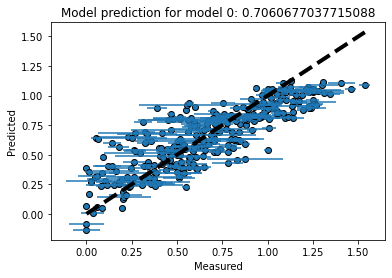

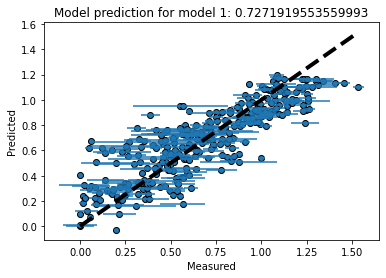

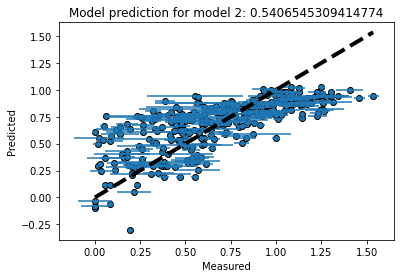

In [17]:
# See what the models do
for i in range(len(ensemble_MLP)):
    model = ensemble_MLP[i]
    y_pred = model.predict(X_data)
    score = sklearn.metrics.r2_score(y_data, y_pred)
    fig, ax = plt.subplots()
    ax.scatter(y_data, y_pred, edgecolors=(0, 0, 0))
    ax.errorbar(y_data, y_pred,xerr = y_std_data, ls='none')
    ax.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_title("Model prediction for model {}: {}".format(i, score))
    ax.set_ylabel('Predicted')
    plt.show()

We can also see the generated ensemble prediction of the n models, including the uncertainty on some points.

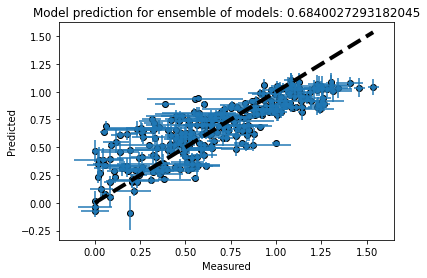

In [18]:
all_predictions = None
for model in ensemble_MLP:
    y_pred = model.predict(X_data)
    answer_array_pred = y_pred.reshape(X_data.shape[0], -1)
    if all_predictions is None:
        all_predictions = y_pred.reshape(X_data.shape[0], -1)
    else:
        all_predictions =np.concatenate((all_predictions, y_pred.reshape(X_data.shape[0], -1)), axis = 1)

y_pred, y_pred_std = np.mean(all_predictions, axis = 1), np.std(all_predictions, axis = 1)
score = sklearn.metrics.r2_score(y_data, y_pred)

fig, ax = plt.subplots()
ax.scatter(y_data, y_pred, edgecolors=(0, 0, 0))
ax.errorbar(y_data, y_pred, xerr = y_std_data, yerr = y_pred_std, ls='none')
ax.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_title("Model prediction for ensemble of models: {}".format(score))
ax.set_ylabel('Predicted')
plt.show()

# Functions for suggesting experimental points

The next step once our ensemble is trained is to use it for the active learning itself.

In [19]:
def generate_random_grid(array_to_avoid, sample_size = 100, normalisation = True, verbose = True):
    
    """
    Generates a random grid of desired size avoiding pre-defined concentrations.
    Can be quite long for big arrays, as it verifies combinations were not previously sampled.
    """
    
    if verbose:
        print("Started generating the random array")
    active_learning_array = None
    answerSize = 0
    while answerSize < sample_size:
        
        this_sample = np.random.randint(0, high=4, size=11, dtype='int')  # 11 concentrations that can move
        if normalisation:
            this_sample_conc = [nad_conc[this_sample[0]], 
                               folinic_acid_conc[this_sample[1]],
                                coa_conc[this_sample[2]], 
                                nucleo_conc[this_sample[3]],
                                spermidine_conc[this_sample[4]],
                                pga_conc[1], 
                                aa_conc[this_sample[6]], 
                                trna_conc[this_sample[7]],
                                mg_gluta_conc[this_sample[8]], 
                                camp_conc[this_sample[9]], 
                                K_gluta_conc[this_sample[10]]                          
                                ]
        else:
            this_sample_conc = [nad_conc[this_sample[0]] * nad_max, 
                               folinic_acid_conc[this_sample[1]] * folinic_acid_max,
                                coa_conc[this_sample[2]] * coa_max, 
                                nucleo_conc[this_sample[3]] * nucleo_mix_max,
                                spermidine_conc[this_sample[4]] * spemidine_max,
                                pga_conc[1] * pga_max, 
                                aa_conc[this_sample[6]] * aa_max, 
                                trna_conc[this_sample[7]] * trna_max,
                                mg_gluta_conc[this_sample[8]] * mg_gluta_max, 
                                camp_conc[this_sample[9]] * camp_max, 
                                K_gluta_conc[this_sample[10]] * K_gluta_max                          
                                ]
        this_sample_conc = np.reshape(this_sample_conc, (1, 11))
        if not present_in_array_index(this_sample_conc, array_to_avoid, size = 11)[0]:
            answerSize = answerSize + 1
            if active_learning_array is None:
                active_learning_array = this_sample_conc
            else:
                active_learning_array = np.concatenate((active_learning_array, this_sample_conc), axis = 0)
            array_to_avoid = np.concatenate((array_to_avoid, this_sample_conc), axis = 0)
    if verbose:
        print("Finished generating the random array")
    return(active_learning_array)


In [20]:
def select_best_predictions_from_ensemble_model(ensemble_of_models, array_to_avoid, 
                                                total_sampling_size = 1000,
                                                sample_size = 500,
                                                exploitation = 1,
                                                exploration = 1.41, 
                                                normalisation = True, 
                                               initial_max = initial_max,
                                               verbose = True): 
    
    """
    Heart of the active learning process.
    Uses a pre-trained ensemble of models to predict on randomly chosen combinations and selects next experiments.
    
    total_sampling_size: number of combinations to randomly sample
    sample_size: number to export for further analysis
    exploitation: weighting of the yield for UCT equivalent
    exploration: weighting of the ucnertainty (yield std) for UCT equivalent 
    normalisation: normalise concentrations (maximum at 1) 
    """
    
    # Random concentrations to test
    active_learning_array  = generate_random_grid(array_to_avoid, sample_size = total_sampling_size, normalisation = normalisation)
    
    # Predicting the full random grid
    answer_array_pred = np.empty
    all_predictions = None
    if verbose:
        print("Starting ensemble predictions")
    for model in ensemble_of_models:
        y_pred = model.predict(active_learning_array)
        answer_array_pred = y_pred.reshape(active_learning_array.shape[0], -1)
        if all_predictions is None:
            all_predictions = y_pred.reshape(active_learning_array.shape[0], -1)
        else:
            all_predictions =np.concatenate((all_predictions, y_pred.reshape(active_learning_array.shape[0], -1)), axis = 1)
    if verbose:
        print("Finished ensemble predictions")    
    
    # Otaining mean and std for predicted array
    y_pred, y_pred_std = np.mean(all_predictions, axis = 1), np.std(all_predictions, axis = 1)
    
    # Create the array to maximise, balancing between exploration and exploitation
    array_to_maximise = copy.deepcopy(exploitation * y_pred + exploration * y_pred_std)
    
    # Select arrays depending on choice of way to eplore: only uncertainty, only yield, or a mix of both.
    conditions_list_pure_exploitation = []
    for count in range(sample_size):
        i = np.argmax(y_pred)
        conditions_list_pure_exploitation.append(int(i))
        if verbose:
            print("Maximising sample {} is yield: {}, std = {}".format(i, y_pred[i], y_pred_std[i]))
        y_pred[i] = -1
        
    conditions_list_pure_exploration = []
    for count in range(sample_size):
        i = np.argmax(y_pred_std)
        conditions_list_pure_exploration.append(int(i))
        if verbose:
            print("Maximising sample {} is yield: {}, std = {}".format(i, y_pred[i], y_pred_std[i]))
        y_pred_std[i] = -1
    
    conditions_list = []
    for count in range(sample_size):
        i = np.argmax(array_to_maximise)
        conditions_list.append(int(i))
        if verbose:
            print("Maximising sample {} is yield: {}, std = {}".format(i, y_pred[i], y_pred_std[i]))
        array_to_maximise[i] = -1

    if normalisation:
        for i in range(active_learning_array.shape[1]):
            active_learning_array[:,i] = active_learning_array[:,i]*initial_max[i]
    else:
        active_learning_array =  active_learning_array
            
    conditions_to_test = active_learning_array[conditions_list,:]
    conditions_to_test_exploration = active_learning_array[conditions_list_pure_exploration,:]
    conditions_to_test_exploitation = active_learning_array[conditions_list_pure_exploitation,:]
    return(conditions_to_test, conditions_to_test_exploration, conditions_to_test_exploitation)

In [21]:
def export_array_of_elements_of_interest(array, file_place):
    
    """
    Export an array as a csv in the destined place
    """
    
    fieldnames = ["nad", "folinic_acid", "DNA", "coa", "RBS", "peg", "nucleo_mix", 
                  "spermidin", "pga", "aa", "trna", "mg_gluta", "hepes", "camp", "K_gluta", "promoter"]
    export_as_list = []
    
    # These parameters were not modified in this project
    peg = 1
    hepes = 1
    
    for row in array:
        new_dict = {}
        new_dict["nad"] = round(float(row[0]), 5)
        new_dict["folinic_acid"] = round(float(row[1]), 5)
        new_dict["DNA"] = 50
        new_dict["coa"] = round(float(row[2]), 5)
        new_dict["RBS"] = 10
        new_dict["peg"] = 2
        new_dict["nucleo_mix"] = round(float(row[3]), 5)
        new_dict["spermidin"] = round(float(row[4]), 5)
        new_dict["pga"] = round(float(row[5]), 5)
        new_dict["aa"] = round(float(row[6]), 5)
        new_dict["trna"] = round(float(row[7]), 5)
        new_dict["mg_gluta"] = round(float(row[8]), 4)
        new_dict["hepes"] = 50
        new_dict["camp"] = round(float(row[9]), 4)
        new_dict["K_gluta"] = round(float(row[10]), 4)
        new_dict["promoter"] = 10
        export_as_list.append(new_dict)
    
    with open(file_place, "w") as csv_handle:
        csv_writer = csv.DictWriter(csv_handle, fieldnames, restval='', extrasaction='ignore')
        csv_writer.writeheader()
        for result in export_as_list:
            csv_writer.writerow(result)



# Active learning

In the article, we used a total sampling size of 100000, and exported samples of 500 combinations.

In [22]:
conditions_to_test, conditions_to_test_exploration, conditions_to_test_exploitation = select_best_predictions_from_ensemble_model(ensemble_of_models = ensemble_MLP, 
                                            array_to_avoid = X_data, 
                                            total_sampling_size = 1000, 
                                            verbose = False,
                                            sample_size = 50)

Started generating the random array
Finished generating the random array


In [23]:
base_name = "showcase_AL"
export_array_of_elements_of_interest(conditions_to_test, file_place = "{}.csv".format(base_name))
export_array_of_elements_of_interest(conditions_to_test_exploration, file_place = "{}_exploration.csv".format(base_name))
export_array_of_elements_of_interest(conditions_to_test_exploitation, file_place = "{}_exploitation.csv".format(base_name))